# Academic test

In [53]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

### Parameters to be used 

In [2]:
T = 1
gamma = 1
alpha_g = 2
beta_g = 1.27 * 10**(-3)
sigma_g = 0.1863
r = 0.02

In [3]:
g_bar = 0.5
g_hat = 2*g_bar

b_hat = 1

## First Numerical Method 

### Parameters to be used 

In [4]:
omega = 2
eps = 10**(-5)

In [5]:
space_steps = 32
time_steps = 40

In [6]:
delta_tau = gamma/time_steps
time_mesh = [n*delta_tau for n in range(time_steps+1)]

Remember: $\hat{B} \in [0,1]$ and $\hat{G} \in [0,1]$.

In [7]:
delta_B = 1/space_steps
B_mesh = [i*delta_B for i in range(space_steps+1)]

delta_G = 1/space_steps
G_mesh = [j*delta_G for j in range(space_steps+1)]

We must solve the linear system: $C(\hat{G})P_i^{n+1} = b_i^n$ at each time step and for each value of $i=1,2,\dots,N_{\hat{B}}-1$.

Question: How to introduce $h$?

## Analytical Solution

In [8]:
def analytical_solution(B, G_tilde, T = 1, t = 0):
    return np.exp((T-t)*B*G_tilde)

<IPython.core.display.Javascript object>


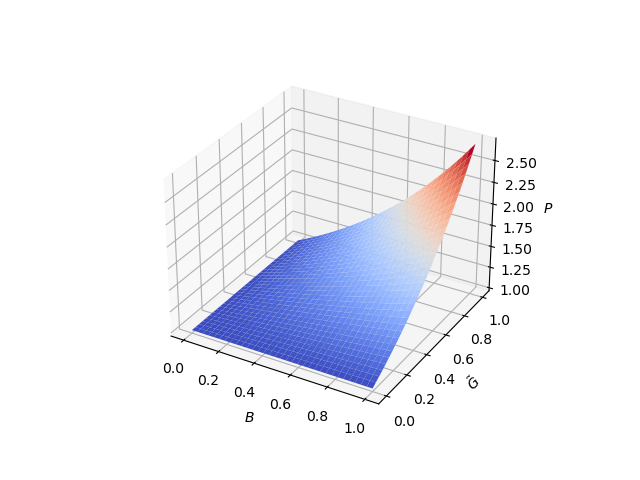

In [9]:


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B, G_tilde = np.meshgrid(B_mesh, G_mesh)

Z = analytical_solution(B, G_tilde)

# Plot the surface.
ax.plot_surface(B, G_tilde, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$B$')
ax.set_ylabel(r'$\tilde{G}$')
ax.set_zlabel(r'$P$')

plt.show()

### $C(\hat{G}) $ matrix 

In this academic test there is no seasonality, that is, $f=0$.

In [10]:
def f():
    return 0

In [11]:
def c1():
    c1_value = 1 + 0.5*r*delta_tau + 0.5* (g_hat**2 * sigma_g**2 * delta_tau)/(delta_G**2)
    return c1_value

def c2(j):
    c2_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) - 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c2_value

def c3(j):
    c3_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) + 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c3_value

In [12]:
C_matrix = [[0 for i in range(space_steps-1)] for j in range(space_steps-1)]

In [13]:
#main diagonal
for i in range(space_steps-1):
    C_matrix[i][i] = c1()
    
#top diagonal
for i in range(space_steps-2):
    C_matrix[i][i+1] = c2(i)
    
#bottom diagonal
for i in range(space_steps-2):
    C_matrix[i+1][i] = c3(i)

### $\left( b_i^n \right)_j$ vector 

This is a vector to be updated in each time step. First you solve the linear system and get to a array $P$ and then subtitute it on the right-hand side of the equation to get the $b$ vector.

In [14]:
def mult_factor1():
    m1_value = (1 - r*delta_tau*0.5) - (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(delta_G**2)
    return m1_value

def mult_factor3():
    m3_value = (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(2 * delta_G**2)
    return m3_value

def mult_factor5():
    m5_value = 0.5 * g_hat * delta_tau * beta_g / (4*delta_G)
    return m5_value


## Solving the linear system and updating values 

In [20]:
#Initializing the variables
P = [[1 for i in range(space_steps-1)] for j in range(time_steps)]
theta = [[1 for i in range(space_steps-1)] for j in range(time_steps)]

In [37]:
def m(theta, P, omega=2):
        if P + theta/(2*omega) <=0:
            a = -theta - 2*omega*P
            return a
        else:
            b = theta + 2*omega*P + omega**2 - omega * np.sqrt(4*theta + 8*omega*P + omega**2)
            return b

In [67]:
#remember to update boundary conditions
for n in range(time_steps):
    theta_n1 = theta.copy()
    P_n = P.copy()
    b = [0 for j in range(space_steps-1)]

    #parameters to start the cycle
    criterion = 1
    eps = 10**(-6)
    k=0
    
    while criterion > eps:
        
        #constructing the b vector
        for j in range(1,space_steps-2):
            b[j] = mult_factor1()*P_n[k][j] +\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j+1] +\
            mult_factor3()*(P_n[k][j+1] + P_n[k][j-1])-\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j-1] +\
            mult_factor5()*(theta_n1[k][j+1]-theta_n1[k][j-1]) + \
            mult_factor5()*(theta_n1[0][j+1]-theta_n1[0][j-1])
        #########
        
        #solving the linear system
        newP = np.linalg.solve(C_matrix, b)
        P_n[k] = newP
        ######
        
        #update theta
        theta_updated = [m(theta_n1[k][j], newP[j]) for j in range(space_steps-1)] #check this
        theta_n1[k+1] = theta_updated
        ######
        
        #stopping test
        theta_updated_array = np.array(theta_updated)
        theta_k_array = np.array(theta_n1[k])
        numerator = np.max(theta_updated_array - theta_k_array)
        denominator = np.max(theta_updated_array)
        criterion = numerator/denominator
        #####
        k+=1
    print(k)
        
    theta[n] = theta_updated
    P[n] = newP


6
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [68]:
theta_n1

[[-0.10516937197292897,
  -0.12179449443148815,
  -0.1451889314185637,
  -0.17548613739644914,
  -0.2086461904881416,
  -0.24230124559429633,
  -0.27935348732510246,
  -0.31511056191658415,
  -0.3623916988481586,
  -0.44481921580698813,
  -0.5497309791430016,
  -0.6557865066725794,
  -0.7480921210594271,
  -0.8205863683798365,
  -0.8735461248142524,
  -0.9103379092659596,
  -0.9350684293922251,
  -0.9513777761447244,
  -0.9620400763501502,
  -0.9690094301633962,
  -0.9735591763976181,
  -0.9765948678916025,
  -0.9784856088532408,
  -0.9800465437971022,
  -0.9802755967764769,
  -0.9824525670092816,
  -0.9787573326132168,
  -0.9881665726900177,
  -0.9622098084505231,
  -0.9999440842006573,
  -0.7949049674417799],
 [0.10516546362047602,
  0.12154226758108792,
  0.14360009171204804,
  0.1692473570355453,
  0.18955935017214628,
  0.1934414978944991,
  0.1711757293099082,
  0.10375988896417385,
  -0.007591422848607365,
  -0.13395191644957993,
  -0.2689070632717332,
  -0.408969605592449,
  -0

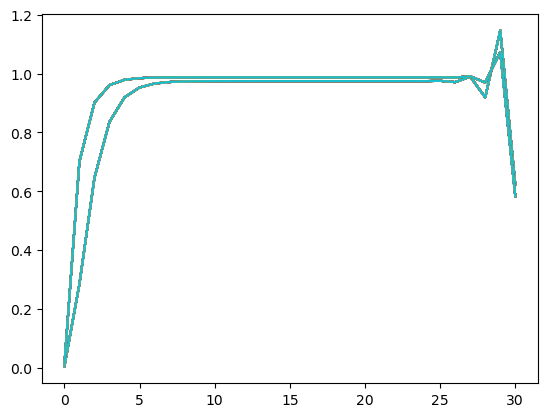

In [58]:
for i in range(len(P)):
    plt.plot(P[i])

In [1]:
crit=4
k=1
while crit>1/8:
    crit=1/k
    k+=1
print(k)

9
